In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
path = "../models/april-27-ft/126-75-3/" # 42-65-9
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/april-27-ft/126-75-3/model


In [3]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calculate_epsg(coord):
    ''' Returns a UTM EPSG for a lat, long coord'''
    ___xx = 10 + ((coord[0] - (-126)) // 6)
    __x__ = 6 if coord[1] > 0 else 7
    return int( str(32) + str(__x__) + str(___xx)[:-2] )


def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    epsg = calculate_epsg(tl)
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


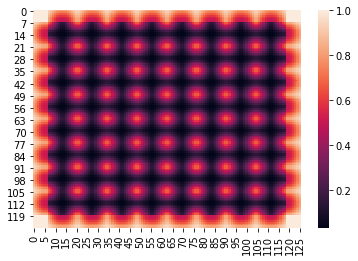

In [4]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6

def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 3.5)
arr = arr[:7, :7]


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



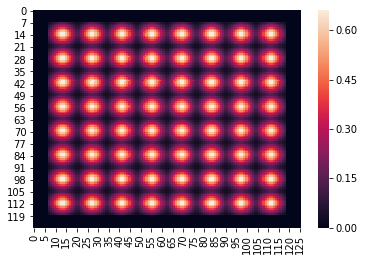

In [5]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(upright)
            
            
            
            

In [18]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
# March 2 model
'''
min_all = [0.020395646858960392,
 0.03833778686821461,
 0.022913980782032013,
 0.08838867269456387,
 0.05731564749032259,
 0.0796274145692587,
 0.08639285631477833,
 0.08918419919908048,
 0.07416137464344502,
 0.04398707151412964,
 0.0,
 0.008659180235117674,
 -0.0134716229327023,
 0.006902076792903247,
 0.006362500241957605,
 4.999999873689376e-05]

max_all = [0.18219037026166907,
 0.27367106080055237,
 0.3996005910634992,
 0.4859166720509528,
 0.4492199122905731,
 0.46700127094984045,
 0.49433933556079857,
 0.5116616946458816,
 0.6353135156631469,
 0.5636022371053693,
 0.3590170443058014,
 0.693415229320526,
 0.3948741647601127,
 0.6290205121040344,
 0.8152220940589849,
 0.14367499947547913]

# March 26 model
min_all = [0.018344340771436693,
 0.03433999095112085,
 0.02109462922438979,
 0.08840075232088565,
 0.05248143896460533,
 0.07554152630269528,
 0.08299643911421299,
 0.08663404531776905,
 0.061478273682296275,
 0.03848250448703766,
 0.0,
 0.007845277478918434,
 -0.019946719538420435,
 0.006319513348862529,
 0.005725000519305468,
 0.0]
           
max_all = [0.20295477986335708,
 0.2974775287508963,
 0.43531390756368504,
 0.5155096459388728,
 0.4817290660738941,
 0.49340617656707764,
 0.5170544689893719,
 0.5285718756914128,
 0.6655139529705045,
 0.6088982224464417,
 0.37388473749160767,
 0.7146827185153959,
 0.4034737709164612,
 0.6469375097751615,
 0.9073999524116516,
 0.16064999997615814]


# April models
max_all = [0.20293334126472473,
 0.2974596872925759,
 0.43528045266866733,
 0.515475255250931,
 0.4816924110054972,
 0.493372516334057,
 0.5170336276292802,
 0.5285584330558777,
 0.665477538108826,
 0.6088601350784302,
 0.37388473749160767,
 0.7146625101566331,
 0.4034559682011605,
 0.6468986928462988,
 0.8434000015258789,
 0.1535000056028366]

min_all = [0.018348615430295468,
 0.03434459343552589,
 0.021097897551953793,
 0.08843073360621931,
 0.05248979106545448,
 0.0755525667220354,
 0.08301881551742556,
 0.08665396682918072,
 0.06150140371173621,
 0.03848193641752005,
 0.0,
 0.007888359110802412,
 -0.019908943679183718,
 0.006355978781357411,
 0.006212499924004078,
 3.7500001781154424e-05]
'''


min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)

def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    pred_files = ["../tile_data/ghana_cocoa/processed/" + str(y_col) + "/" + str(folder) + ".npy"]
    pred_x = []
    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))

    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, 
                                                 clipping_params['rmax']: 5,
                                                 clipping_params['rmin']: 0,
                                                 clipping_params['dmax']: 3,
                                                 length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    print(np.array(preds).shape)        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

(126, 126)


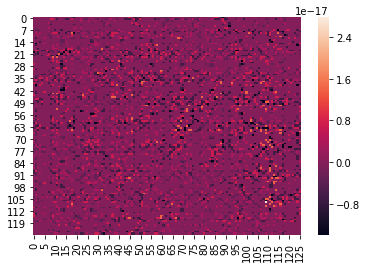

In [8]:
x = np.load("../tile_data/honduras/processed/{}/{}.npy".format(str(0), str(0)))

def validate_tiling(arr):
    arr = arr
    preds = tile_images(arr, None)
    preds_stacked = []
    preds = np.stack(preds)
    preds = preds[:, 0, 1:-1, 1:-1, 0]
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    print(stacked.shape)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

x1 = validate_tiling(x)
sns.heatmap(x[0, 1:-1, 1:-1, 0] - x1) 

In [9]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [10]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

In [11]:
from time import sleep
all_preds = []
for row in tnrange(0, 5):
    for column in range(0, 5):
        x = np.load("../tile_data/honduras/processed/{}/{}.npy".format(str(row), str(column)))
        all_preds.append(x)
#all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 2)

In [12]:
idx = 0

1


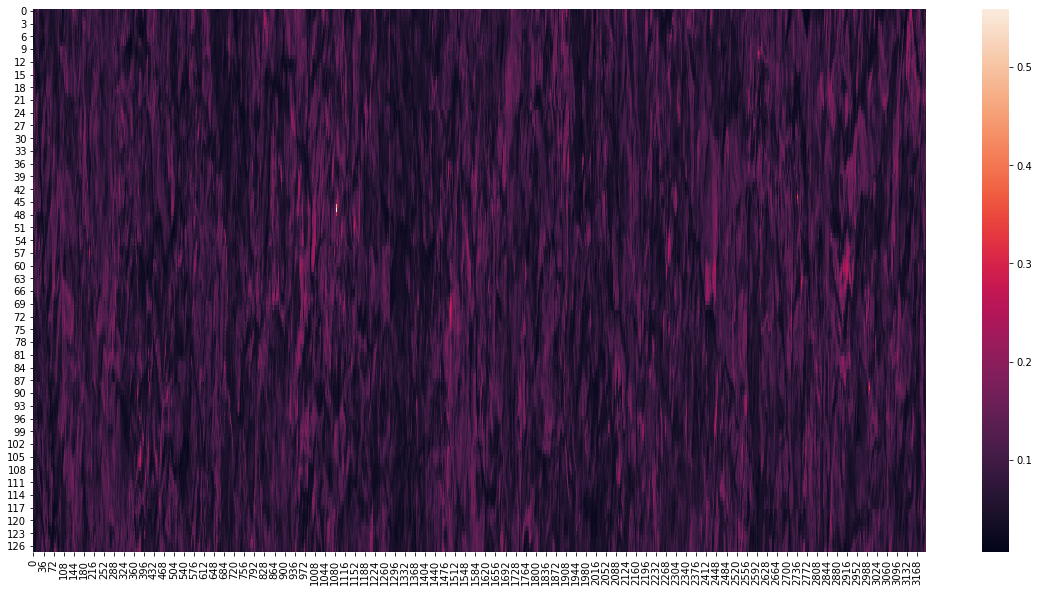

In [13]:
idx += 1
print(idx)
plt.figure(figsize=(20, 10))
#sns.heatmap(np.max(stacked[:, :, :, 4], 0) - np.min(stacked[:, :, :, 4], 0))
sns.heatmap(stacked[idx, :, :, 2])

In [19]:
from time import sleep
all_preds = []
for row in tnrange(0, 5):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 5)]
    pred_i = np.concatenate(pred_i, axis = 1)
    #np.save("../tile_data/honduras_large/output/{}.npy".format(row), pred_i)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)
(289, 14, 14)



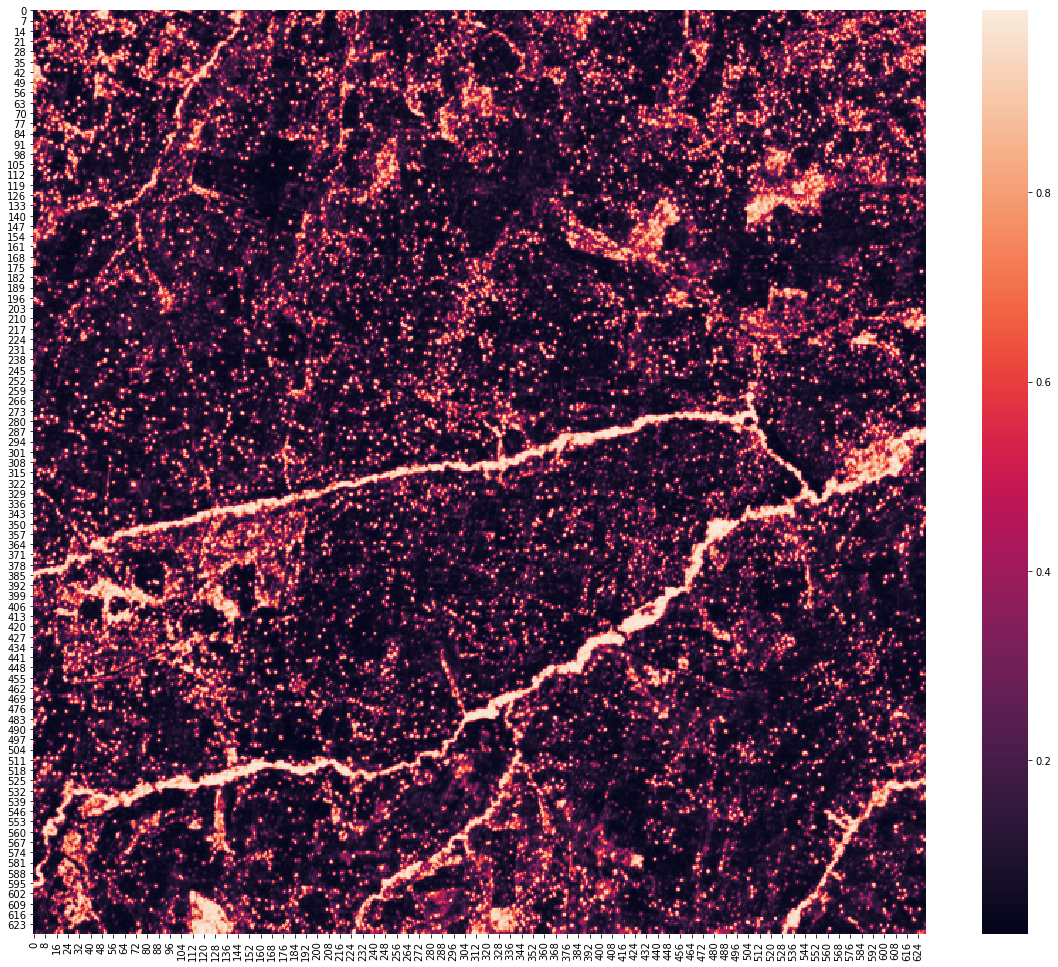

In [41]:
# Epoch 71
stacked = np.concatenate(all_preds, axis = 0)
stacked[np.isnan(stacked)] = 0.
plt.figure(figsize=(20, 17))
sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

In [42]:
thresh = 0.25 # .125, 0.3 is best rn
thresh_p = 0.35

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh * 2 and cur_window[4, 2] < thresh * 2 :
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh * 2 and cur_window[2, 4] < thresh * 2:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh * 2 and cur_window[1, 3] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh * 2 and cur_window[3, 1] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

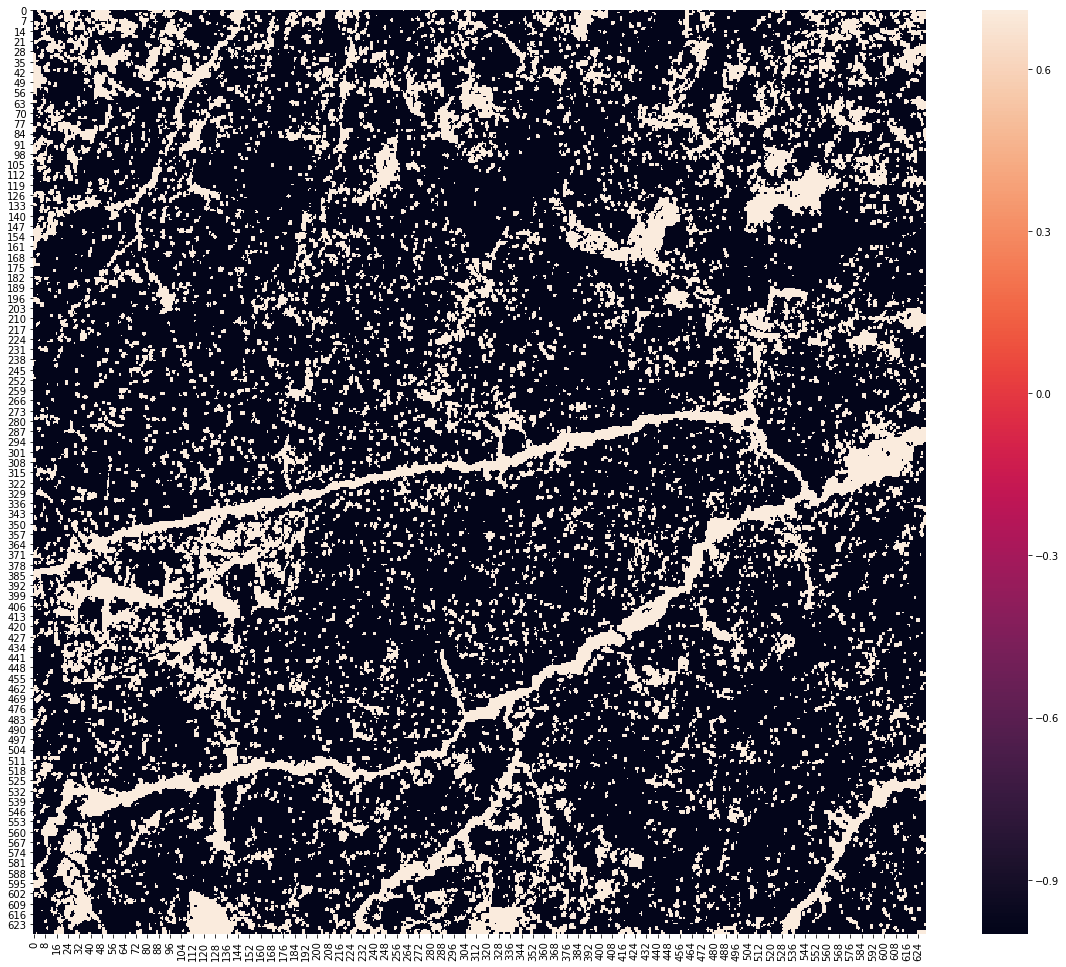

In [43]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
stacked[np.where(stacked > thresh_p)] = 0.71
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 1.
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

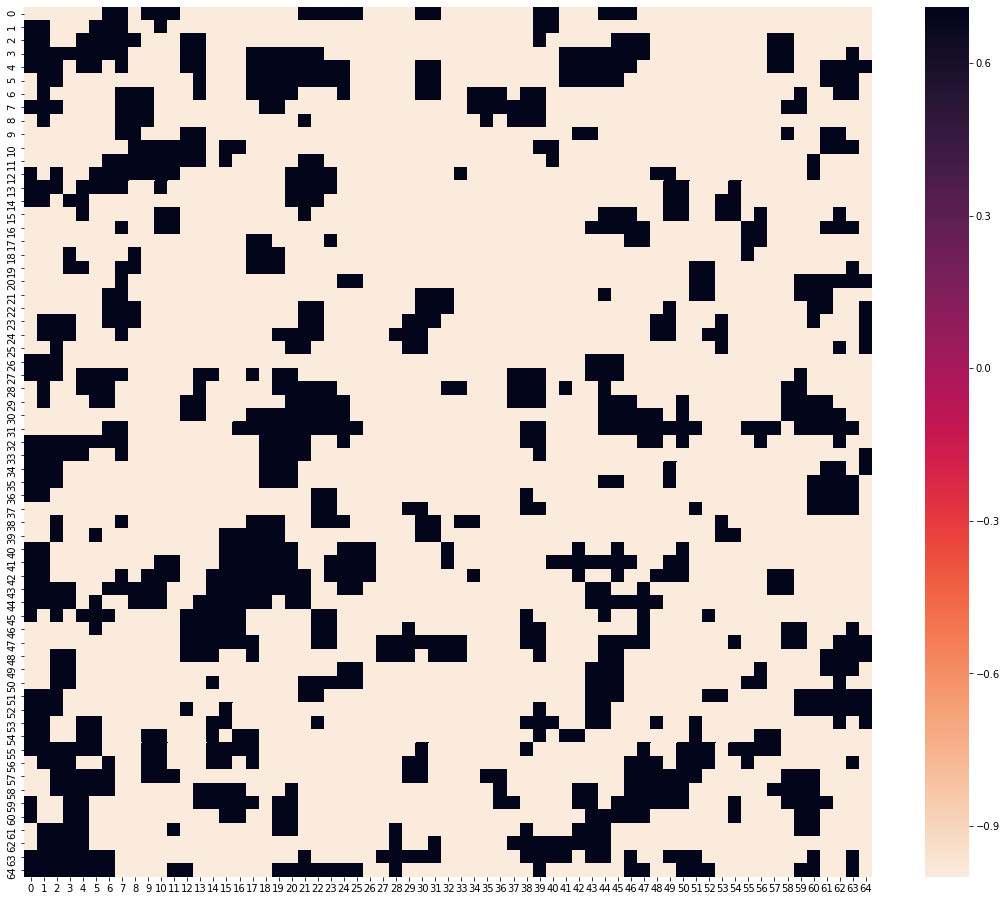

In [41]:
plt.figure(figsize=(19, 16)) # : ,96:155
sns.heatmap(stacked[340:405, 98:163], cmap = sns.cm.rocket_r)

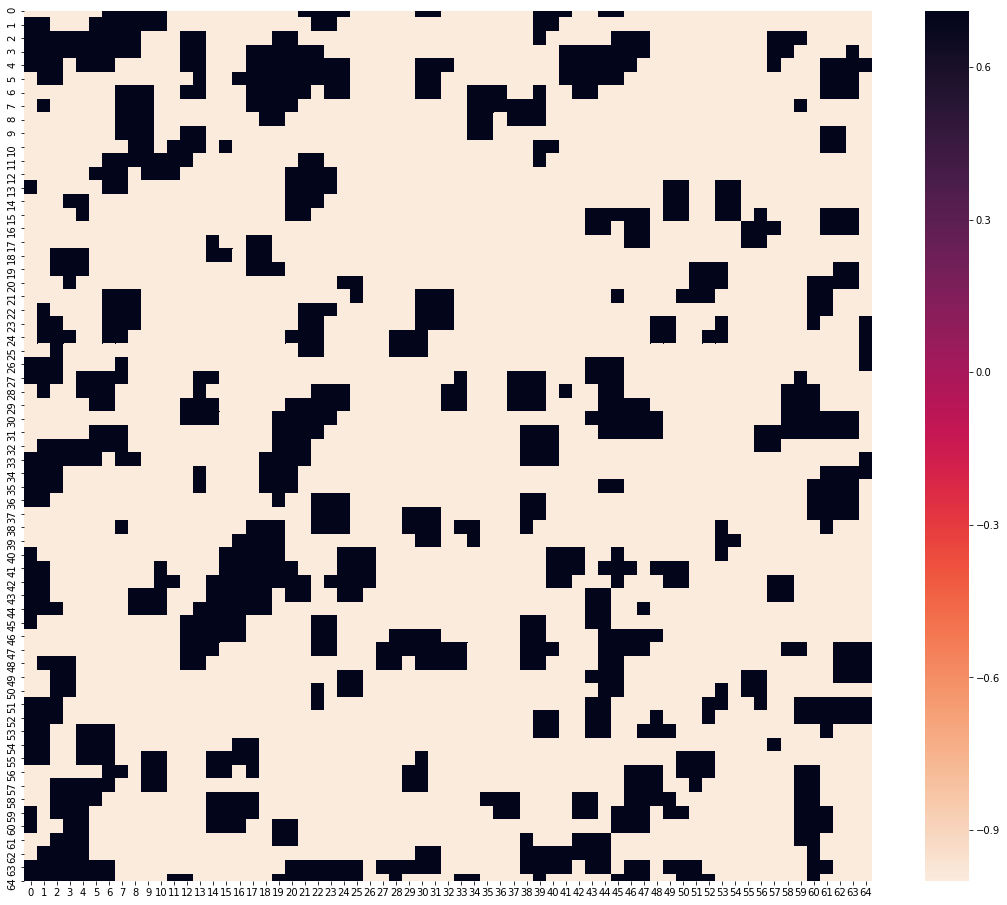

In [22]:
plt.figure(figsize=(19, 16)) # : ,96:155
sns.heatmap(stacked[340:405, 98:163], cmap = sns.cm.rocket_r)

In [53]:
#plt.figure(figsize=(9, 15)) # GHANA
#sns.heatmap(stacked[250:450, 350:450])
#stacked = stacked[200:400, 1800:1900]

In [44]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
##coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (-20.147320, -40.837770) # ESPERITO SANTO BR 2
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (4.179529, -74.889171) # , colombia
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.727334, -90.015579) # elsalvador imposible
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (12.398014, -86.963042) # Nicaragua
#coords = (13.933745, -84.690842) # Bonanza, Nicaragua
#coords = coords = (14.096664, -88.720304) # Honduras
#coords = (14.064689, -60.967060) # St. Lucia
#coords = (15.825856, -15.341662) # senegal

#-15.3396265973683
coords = (coords[1], coords[0])
#bl = bounding_box(coords, (0*1260)+0, (1*1260)-0, expansion = 0) # -85, +135 el salv
#bl = bounding_box(coords, 370, 1220, expansion = 0)
#coords = (bl[0][0], bl[0][1])
#p#oint = bounding_box(coords, 370+650, 1220+600, expansion = 0)
point = bounding_box(coords, (5*1260)-0, (5*1260)-0, expansion = 0) # -85, +135 el salv # +10, -220 hond
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]
# -15.33, 15.833, 

[6300.0, 6300.0]


In [45]:
point

[(-1.211931257155192, 7.454846307764278),
 (-1.2692229999999998, 7.398111000000001)]

In [46]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/upperwest.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

# Cloud optimized Geotiff

In [126]:
!gdal_translate ../../ce-hosting/includes/honduras.tif honduras.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro honduras.tif 2 4 8 16 32
#!gsutil cp niger.tif gs://restoration-hosting/niger.tif

Input file size is 4410, 4410
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


# Half-hectare tree density Geotiff

In [48]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.8)
summed += 0.1

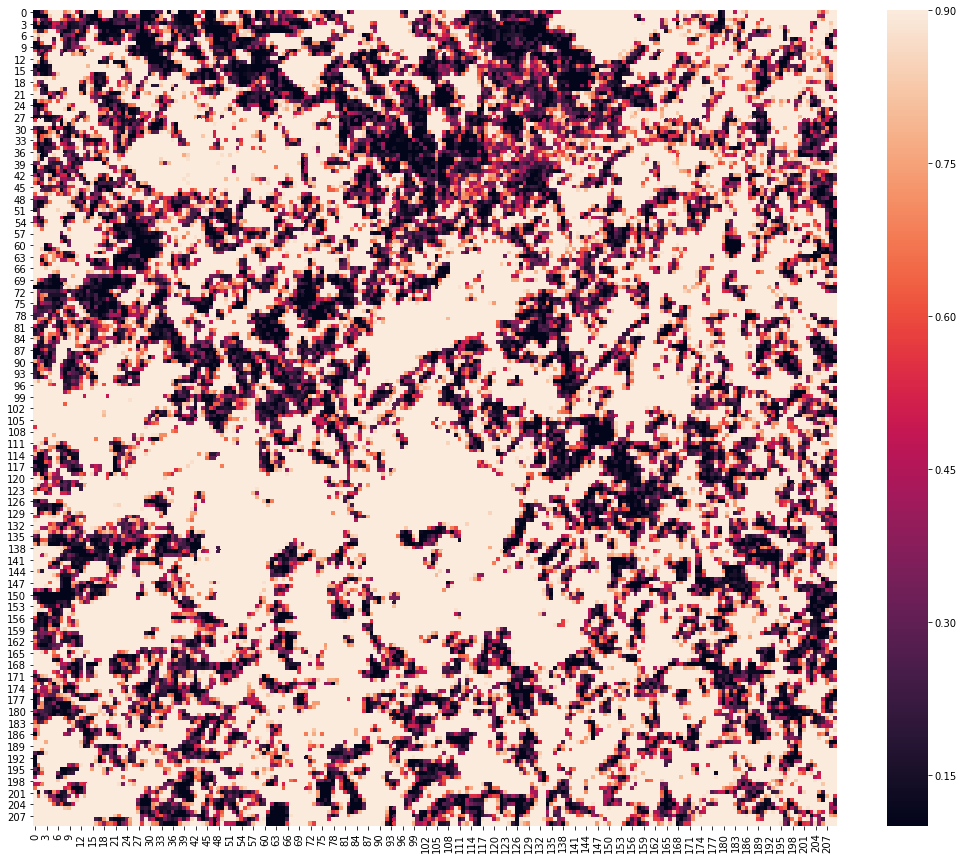

In [49]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [50]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()